In [57]:
# Import libraries
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import os, os.path as osp

import nltk  #to install: activate ada,   conda install -c anaconda nltk
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from ast import literal_eval
#nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import string


In [3]:
meat_products = ['steak','lamb', 'beef', 'cheese', 'pork', 'turkey', 'chicken', 'tuna', 'egg']


In [4]:
#Import CSV
DATA_FOLDER='data'
df=pd.read_csv(DATA_FOLDER+'/recipes_data_34p.csv')
df
df2=pd.read_csv(DATA_FOLDER+'/recipes_data_14p.csv')
df = df.append(df2)
df.drop_duplicates
df
#recipes_df[recipes_df['Has meat']].count()



,Recipe Title,Has meat,Meat types,Meat quantity (kg),Carbon footprint,Rating,Website
0,French Dip Sandwiches Recipe : Rachael Ray : R...,True,"['beef', 'beef', 'beef']","[0.0, 0.17006802721088435, 0.0]",4.591837,5.00,food network
1,Apple Brown Betty Recipe | MyRecipes.com,False,[],0,0.000000,NaN,myrecipes
2,Roasted Potatoes with North Indian Spices Reci...,False,[],0,0.000000,NaN,myrecipes
3,\r\n\tBaked Buffalo Wings Recipe - Allrecipes....,True,['chicken'],[0.0],0.000000,4.40,allrecipes
4,Baked Lemon-Garlic Chicken with Bell Peppers R...,True,"['chicken', 'chicken']","[0.24499595756670015, 0.24499595756670015]",3.380944,NaN,myrecipes
5,\r\n\tFast Rice Pudding Recipe - Allrecipes.co...,False,[],0,0.000000,4.10,allrecipes
6,Mississippi Mud Pie Recipe | MyRecipes.com,True,['egg'],[0.002181818181818182],0.010473,NaN,myrecipes
7,\r\n\tChicken Breast Cutlets with Artichokes a...,True,"['chicken', 'chicken']","[0.1511715797430083, 0.0]",1.043084,4.40,allrecipes
8,\r\n\tBest Ever Popcorn Balls Recipe - Allreci...,False,[],0,0.000000,4.40,allrecipes
9,Pumpkin Oatmeal Recipe : Aarti Sequeira : Reci...,False,[],0,0.000000,5.00,food network


### Data Cleaning
Although we did most of the data cleaning in the previous notebook, we still need to clean out titles from the CSV file, annd remove outliers or other discrepancies that arose when analysing the data from our csv file.

In [5]:
#Remove the '\n', '\r' and '\t' left out of the DF -> CSV -> DF conversion
df_cleaned = df.copy()
df_cleaned['Recipe Title'] = df_cleaned['Recipe Title'].str.replace('\n', '')
df_cleaned['Recipe Title'] = df_cleaned['Recipe Title'].str.replace('\t', '')
df_cleaned['Recipe Title'] = df_cleaned['Recipe Title'].str.replace('\r', '')

#remove incoherent values (inf) in carbon footprint
df_cleaned['Carbon footprint'] = df_cleaned['Carbon footprint'].replace([np.inf, np.nan], 0)

In [6]:
df_cleaned.head(5)

,Recipe Title,Has meat,Meat types,Meat quantity (kg),Carbon footprint,Rating,Website
0,French Dip Sandwiches Recipe : Rachael Ray : R...,True,"['beef', 'beef', 'beef']","[0.0, 0.17006802721088435, 0.0]",4.591837,5.0,food network
1,Apple Brown Betty Recipe | MyRecipes.com,False,[],0,0.000000,NaN,myrecipes
2,Roasted Potatoes with North Indian Spices Reci...,False,[],0,0.000000,NaN,myrecipes
3,Baked Buffalo Wings Recipe - Allrecipes.com,True,['chicken'],[0.0],0.000000,4.4,allrecipes
4,Baked Lemon-Garlic Chicken with Bell Peppers R...,True,"['chicken', 'chicken']","[0.24499595756670015, 0.24499595756670015]",3.380944,NaN,myrecipes


In [18]:
#sort dataframe
df_sorted_meat = df_cleaned.sort_values(['Carbon footprint'], ascending=False).reset_index(drop=True)

#manually remove outliers, to be replaced with a threshold check
#df_sorted_meat = df_sorted_meat.drop(df_sorted_meat.index[0:100]).reset_index(drop=True)
df_sorted_meat.head(5)

#remove all non-meat ingredients
df_sorted_meat = df_sorted_meat[df_sorted_meat['Has meat'] == True]

#remove infinite and NaN values
#df_sorted_meat=df_sorted_meat.replace([np.inf,-np.inf], np.nan).dropna(subset=["Carbon footprint", "Rating"], how="any")
df_sorted_meat = df_sorted_meat.replace([np.inf, np.nan], 0)

In [8]:
df_sorted_meat

,Recipe Title,Has meat,Meat types,Meat quantity (kg),Carbon footprint,Rating,Website
0,Manny's Manly Meat Sauce Recipe : Rachael Ray ...,True,"['beef', 'beef']","[10.317460317460316, 0.0]",278.571429,4.0,food network
1,Manny's Manly Meat Sauce Recipe : Rachael Ray ...,True,"['beef', 'beef']","[10.317460317460316, 0.0]",278.571429,4.0,food network
2,Beef and Almond Stuffed Zucchini Boats Recipe ...,True,['beef'],[10.260770975056689],277.040816,4.0,allrecipes
3,Salisbury Steak with Brown Gravy Recipe : Sand...,True,"['beef', 'egg', 'beef']","[9.240362811791384, 0.0015, 0.11339797017633384]",252.558741,5.0,food network
4,Salisbury Steak Dinner Recipe from Betty Crocker,True,"['egg', 'beef', 'beef']","[0.0015, 9.183673469387754, 0.09213585076827124]",250.454052,0.0,betty crocker
5,Bo Burger Recipe : Paula Deen : Recipes : Food...,True,"['beef', 'egg', 'cheese']","[9.240362811791384, 0.006, 0.0]",249.518596,5.0,food network
6,Stuffed Peppers Recipe from Betty Crocker,True,"['beef', 'cheese']","[9.183673469387754, 0.026577649260078245]",248.317982,0.0,betty crocker
7,Easy Meatballs Recipe from Betty Crocker,True,"['beef', 'egg']","[9.183673469387754, 0.0015]",247.966384,0.0,betty crocker
8,Grilled Juicy Burgers Recipe from Betty Crocker,True,"['egg', 'beef']","[0.0015, 9.183673469387754]",247.966384,0.0,betty crocker
9,Grilled Juicy Burgers Recipe from Betty Crocker,True,"['egg', 'beef']","[0.0015, 9.183673469387754]",247.966384,0.0,betty crocker


### Data exploration and basic analysis


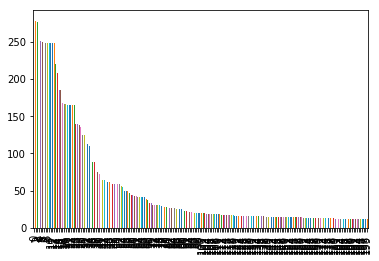

In [10]:
#Lets plot the biggest impact recipes
df_sorted_meat['Carbon footprint'].head(200).plot(kind='bar',y='Carbon footprint')

We can see the biggest impact recipes have a carbon footprint orders of magnitude above the other recipes' footprint; the tailof the distribution flattens out in the end.

In [23]:
#remove recipes with a zero score
df_sorted_meat = df_sorted_meat[df_sorted_meat['Carbon footprint'] >= 0.1]

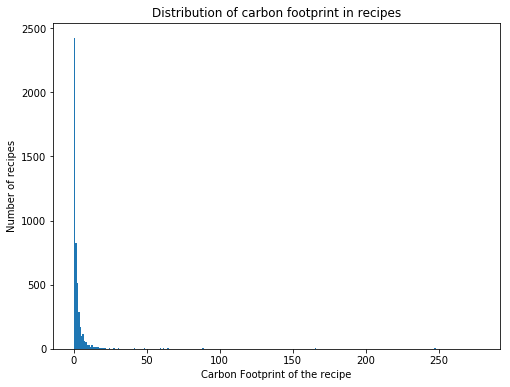

In [24]:
# Plot the distribution of carbon footprint

binwidth = 1
min_val  = min(df_sorted_meat['Carbon footprint'])
max_val = max(df_sorted_meat['Carbon footprint'])
ticks = np.arange(min_val,max_val,binwidth)

plt.figure(figsize=(8,6))
plt.hist(df_sorted_meat['Carbon footprint'], bins=np.arange(min_val, max_val, binwidth))

plt.xlabel('Carbon Footprint of the recipe')
plt.ylabel('Number of recipes')
plt.title('Distribution of carbon footprint in recipes')
plt.show()

We can see that even applying a threshold on the lower value of the carbon footprint (here 100g per recipe), we still have a distribution with a long tail. We can try plotting the data on a logarithmic scale

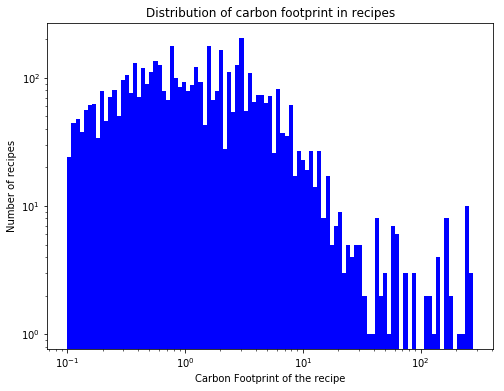

In [26]:
# Plot the distribution of carbon footprint

bins = 100
min_val  = min(df_sorted_meat['Carbon footprint'])
max_val = max(df_sorted_meat['Carbon footprint'])
ticks = np.arange(min_val,max_val,bins)

plt.figure(figsize=(8,6))

logbins=np.logspace(np.log10(min_val),np.log10(max_val),bins)
plt.hist(df_sorted_meat['Carbon footprint'], bins=logbins,color='blue')
                    
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Carbon Footprint of the recipe')
plt.ylabel('Number of recipes')
plt.title('Distribution of carbon footprint in recipes')
plt.show()

### Assumptions
We assume we can assign a "median" carbon footprint value to all recipes in which we detected meat ingredients but couldn't extract a meat quantity. 

In [158]:
#Re-map the dataframe to one with columns with quantities and carbon footprints for every meat ingredient
meat_qty = df_sorted_meat.copy()
meat_qty.head(15)

,Recipe Title,Has meat,Meat types,Meat quantity (kg),Carbon footprint,Rating,Website
0,Manny's Manly Meat Sauce Recipe : Rachael Ray ...,True,"['beef', 'beef']","[10.317460317460316, 0.0]",278.571429,4.0,food network
1,Manny's Manly Meat Sauce Recipe : Rachael Ray ...,True,"['beef', 'beef']","[10.317460317460316, 0.0]",278.571429,4.0,food network
2,Beef and Almond Stuffed Zucchini Boats Recipe ...,True,['beef'],[10.260770975056689],277.040816,4.0,allrecipes
3,Salisbury Steak with Brown Gravy Recipe : Sand...,True,"['beef', 'egg', 'beef']","[9.240362811791384, 0.0015, 0.11339797017633384]",252.558741,5.0,food network
4,Salisbury Steak Dinner Recipe from Betty Crocker,True,"['egg', 'beef', 'beef']","[0.0015, 9.183673469387754, 0.09213585076827124]",250.454052,0.0,betty crocker
5,Bo Burger Recipe : Paula Deen : Recipes : Food...,True,"['beef', 'egg', 'cheese']","[9.240362811791384, 0.006, 0.0]",249.518596,5.0,food network
6,Stuffed Peppers Recipe from Betty Crocker,True,"['beef', 'cheese']","[9.183673469387754, 0.026577649260078245]",248.317982,0.0,betty crocker
7,Easy Meatballs Recipe from Betty Crocker,True,"['beef', 'egg']","[9.183673469387754, 0.0015]",247.966384,0.0,betty crocker
8,Grilled Juicy Burgers Recipe from Betty Crocker,True,"['egg', 'beef']","[0.0015, 9.183673469387754]",247.966384,0.0,betty crocker
9,Grilled Juicy Burgers Recipe from Betty Crocker,True,"['egg', 'beef']","[0.0015, 9.183673469387754]",247.966384,0.0,betty crocker


In [303]:
def meat_quantities(recipe_data):
    '''
    Input: recipe dataframe row. Output: meat quantity dataframe.
    Reads and converts the list of meat ingredients and quantities from string to values then creates
    and returns a DataFrame with all meat quantitities per meat type.
    '''
    columns = literal_eval(recipe_data['Meat types'])
    rows = literal_eval(recipe_data['Meat quantity (kg)']) 
    
    df = pd.DataFrame(np.array(rows).reshape(1,len(rows)), columns=columns)
    
    for meat in meat_products2:
        if meat in df.columns.values:
            df[meat] = pd.DataFrame(df[meat]).sum(axis=1)
    
    df = df.T.drop_duplicates().T.reindex(labels=meat_products, axis='columns')

    return df

In [316]:
def meat_quantities_s(recipe_data):
    '''
    Input: recipe dataframe row. Output: meat quantity dataframe.
    Reads and converts the list of meat ingredients and quantities from string to values then creates
    and returns a DataFrame with all meat quantitities per meat type.
    '''
    columns = literal_eval(recipe_data['Meat types'])
    rows = literal_eval(recipe_data['Meat quantity (kg)']) 
    
    df = pd.DataFrame(np.array(rows).reshape(1,len(rows)), columns=columns)
    
    for meat in meat_products2:
        if meat in df.columns.values:
            df[meat] = pd.DataFrame(df[meat]).sum(axis=1)
    
    df = df.T.drop_duplicates().T.reindex(labels=meat_products, axis='columns')

    return df.iloc[0]

In [298]:
meat_quantities(df_cleaned.iloc[0])


,steak,lamb,beef,cheese,pork,turkey,chicken,tuna,egg
0,NaN,NaN,0.170068,NaN,NaN,NaN,NaN,NaN,NaN


In [320]:
meat_qty_df = pd.DataFrame
    
for i in np.arange(len(df_cleaned)):
    new_row = meat_quantities(df_cleaned[df_cleaned['Carbon footprint'] > 0].iloc[i])
    print(new_row[0])
    meat_qty_df = meat_qty_df.append(new_row[0]) #(meat_quantities(df_cleaned[df_cleaned['Carbon footprint'] > 0].iloc[i]))

print(meat_qty_df)

   steak  lamb      beef  cheese  pork  turkey  chicken  tuna  egg
0    NaN   NaN  0.170068     NaN   NaN     NaN      NaN   NaN  NaN


KeyError: 0

In [300]:
 meat_qty_df = df_cleaned.apply(meat_quantities, axis=1)

TypeError: ("object of type 'int' has no len()", 'occurred at index 1')

In [ ]:
#Extract median value for each type of meat quantity
    #Done by Nadine?

In [ ]:
#Assign this median value to all zeroes in meat quantities

In [ ]:
#Group meat quantities per meat type

### Clustering 

In [ ]:

#remove website and meat value from title (NEEDED FOR CLUSTERING)
def tolkenize_title(title_str, recipe_site):
    """
    
    input:
    title_str = full recipe title
    recipe_site = website where recipe is from
    output:
    word_tokens = only the relevant keywords from the title (excluding website, stopwords, punctuation and meat keywords)
    
    """
    #make title lowercase
    title_str=title_str.casefold()
    
    #remove recipe site
    title_str=re.sub(recipe_site,'',title_str)
    title_str=re.sub('.com', '',title_str)
    title_str=re.sub('recipe', '',title_str)
    if 'betty' in title_str: #betty crocker has the form 'bettycrocker' and 'betty crocker'
        title_str=re.sub('bettycrocker','', title_str)
        
    #remove meat products from title to avoid clustering meat with meat....MAYBE WE SHOULDN'T DO THIS..?
    for i in meat_products:
        title_str=re.sub(i, '',title_str)
    
    #remove punctuation
    title_str="".join((char for char in title_str if char not in string.punctuation))

    stop_words=set(stopwords.words('english'))
    word_tokens = word_tokenize(title_str)
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    
    #print('word tokens=',word_tokens) 
    #print('filtered sentence = ',filtered_sentence) 
    #print('title str = ',title_str)

    return filtered_sentence

tolkenize_title('the Simple Collard Chicken of !! Greens Recipe | BettyCrocker.com', 'betty crocker')
    
    
    

In [ ]:
#transfer corpus into vector space

#calculating distance between each title as a measure of similarity

#clustering the documents using the k-means algorithm


#using multidimensional scaling to reduce dimensionality within the corpus
